# **Fine-tuning Wav2Vec2 for Vietnamesswith 🤗 Transformers**

Wav2Vec2 is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.

Using a novel contrastive pretraining objective, Wav2Vec2 learns powerful speech representations from more than 50.000 hours of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/wav2vec2.png)

For the first time, it has been shown that pretraining, followed by fine-tuning on very little labeled speech data achieves competitive results to state-of-the-art ASR systems. Using as little as 10 minutes of labeled data, Wav2Vec2 yields a word error rate (WER) of less than 5% on the clean test set of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) - *cf.* with Table 9 of the [paper](https://arxiv.org/pdf/2006.11477.pdf).

In this notebook, we will give an in-detail explanation of how Wav2Vec2's pretrained checkpoints can be fine-tuned on any English ASR dataset. Note that in this notebook, we will fine-tune Wav2Vec2 without making use of a language model. It is much simpler to use Wav2Vec2 without a language model as an end-to-end ASR system and it has been shown that a standalone Wav2Vec2 acoustic model achieves impressive results. For demonstration purposes, we fine-tune the "base"-sized [pretrained checkpoint](https://huggingface.co/facebook/wav2vec2-base) on the rather small [Timit](https://huggingface.co/datasets/timit_asr) dataset that contains just 5h of training data.

Wav2Vec2 is fine-tuned using Connectionist Temporal Classification (CTC), which is an algorithm that is used to train neural networks for sequence-to-sequence problems and mainly in Automatic Speech Recognition and handwriting recognition. 

I highly recommend reading the blog post [Sequence Modeling with CTC (2017)](https://distill.pub/2017/ctc/) very well-written blog post by Awni Hannun.

First, let's try to get a good GPU in our colab! With Google Colab's free version it's sadly becoming much harder to get access to a good GPU. With Google Colab Pro, one has a much easier time getting access to a V100 or P100 GPU however.

In [9]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


Before we start, let's install both `datasets` and `transformers` from master. Also, we need the `librosa` package to load audio files and the `jiwer` to evaluate our fine-tuned model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric ${}^1$.

In [10]:

!pip install datasets
!pip install transformers==4.22.2
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Prepare Data, Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text. 

In 🤗 Transformers, the Wav2Vec2 model is thus accompanied by both a tokenizer, called [Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer), and a feature extractor, called [Wav2Vec2FeatureExtractor](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2featureextractor).

Let's start by creating the tokenizer responsible for decoding the model's predictions.

### Create Wav2Vec2CTCTokenizer

The [pretrained Wav2Vec2 checkpoint]( ) maps the speech signal to a sequence of context representations as illustrated in the figure above. A fine-tuned Wav2Vec2 checkpoint needs to map this sequence of context representations to its corresponding transcription so that a linear layer has to be added on top of the transformer block (shown in yellow). This linear layer is used to classifies each context representation to a token class analogous how, *e.g.*, after pretraining a linear layer is added on top of BERT's embeddings for further classification - *cf.* with *"BERT"* section of this [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder).

The output size of this layer corresponds to the number of tokens in the vocabulary, which does **not** depend on Wav2Vec2's pretraining task, but only on the labeled dataset used for fine-tuning. So in the first step, we will take a look at Timit and define a vocabulary based on the dataset's transcriptions.

Let's start by loading the dataset and taking a look at its structure.

In [11]:
from datasets import load_dataset, load_metric, DatasetDict

timit = load_dataset("vivos")


  0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
timit

DatasetDict({
    train: Dataset({
        features: ['speaker_id', 'path', 'audio', 'sentence'],
        num_rows: 11660
    })
    test: Dataset({
        features: ['speaker_id', 'path', 'audio', 'sentence'],
        num_rows: 760
    })
})

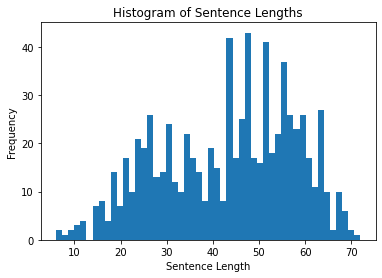

In [13]:
import matplotlib.pyplot as plt
sentence_lengths = [len(example["sentence"]) for example in timit['test']]

# Plot the histogram of transcript lengths
plt.hist(sentence_lengths, bins=50)
plt.title("Histogram of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Frequency")
plt.show()

Many ASR datasets only provide the target text, `'text'` for each audio `'audio'` and file `'file'`. Timit actually provides much more information about each audio file, such as the `'phonetic_detail'`, etc., which is why many researchers choose to evaluate their models on phoneme classification instead of speech recognition when working with Timit. However, we want to keep the notebook as general as possible, so that we will only consider the transcribed text for fine-tuning.



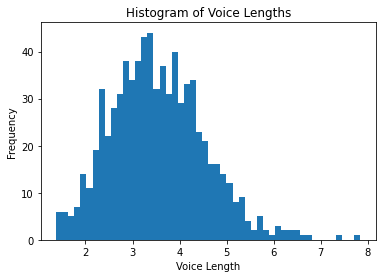

In [14]:
import matplotlib.pyplot as plt
Voice_lengths = [len(example["audio"]['array'])/16000 for example in timit['test']]

# Plot the histogram of transcript lengths
plt.hist(Voice_lengths, bins=50)
plt.title("Histogram of Voice Lengths")
plt.xlabel("Voice Length")
plt.ylabel("Frequency")
plt.show()

In [15]:
timit = timit.remove_columns([ "speaker_id"])

Let's write a short function to display some random samples of the dataset and run it a couple of times to get a feeling for the transcriptions.

In [16]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [17]:
show_random_elements(timit["train"].remove_columns(["audio", "path"]), num_examples=10)

,sentence
0,NHIỀU Ý KIẾN CÒN CHO RẰNG VIỆC KHAI THÁC HÌNH THỂ HƠI QUÁ TAY TRONG TẬP ĐẦU TIÊN LÀ SỰ CÂU KHÁCH HƠI BỊ
1,NGƯỜI LỚN CÒN KHÔNG QUAN TÂM NÓI GÌ ĐẾN NHỮNG BẠN TRẺ
2,MÀ LẠI ĐỦ NHẸ ĐỂ CÓ THỂ MANG SANG PHÒNG BÊN
3,TRẦN ĐẾ QUỸ ĐÃ LÃNH ĐẠO DÂN NAM ĐOẠT ĐƯỢC THẮNG LỢI SAU THẤY DÂN CÙNG KIỆT ĐÓI KHÁT MÁU ĐỔ XƯƠNG RƠI
4,BẢY MƯƠI BỐN BẢY MƯƠI LĂM
5,ÔNG ĐƯỢC ÔNG CHỦ DOANH NGHIỆP TƯ NHÂN QUANG TUYẾN CHO VÀO NHẬN KHOÁN MỘT HẦM ĐÁ LÀM ĐƯỢC NHIỀU THÌ HƯỞNG NHIỀU
6,TRƯỚC ĐÀN CÓ ĐÀO HỒ VUÔNG LÀM MINH ĐƯỜNG
7,VÀ VÔI VỮA TRÓC LẢ TẢ
8,ÔNG CHỈ CÒN BIẾT MỈM CƯỜI LẮC ĐẦU VÀ NGỒI IM KHÔNG DÁM ĐỘNG ĐẬY
9,ĐÓ LÀ ÔNG THẦY NGƯỜI BỒ ĐÀO NHA NÀY XIN MUA NĂM CHIẾC XE LĂN


Alright! The transcriptions look very clean and the language seems to correspond more to written text than dialogue. This makes sense taking into account that vivos is a read speech corpus.

We can see that the transcriptions contain some special characters, such as `,.?!;:`. Without a language model, it is much harder to classify speech chunks to such special characters because they don't really correspond to a characteristic sound unit. *E.g.*, the letter `"s"` has a more or less clear sound, whereas the special character `"."` does not.
Also in order to understand the meaning of a speech signal, it is usually not necessary to include special characters in the transcription.

In addition, we normalize the text to only have lower case letters and append a word separator token at the end.

In [18]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["sentence"] = re.sub(chars_to_ignore_regex, '', batch["sentence"]).lower() + " "
    return batch

In [19]:
timit = timit.map(remove_special_characters)

Map:   0%|          | 0/11660 [00:00<?, ? examples/s]

Map:   0%|          | 0/760 [00:00<?, ? examples/s]

In [20]:
show_random_elements(timit["train"].remove_columns(["audio", "path"]))

,sentence
0,ông tào hữu phùng chia sẻ tôi thấy đây là vấn đề rất bức xúc
1,cô hoàn toàn tin tưởng vào những gì mà cô đọc được trên sách báo
2,điều ấn tượng nhất là anh nhân viên mới này không thích đi nhậu
3,làm sao để có tiền nhanh nhất
4,tôi nghĩ không riêng tôi mà rất nhiều người đang rơi nước mắt như tôi
5,anh phải trả lời cho bằng được câu hỏi bâng khuâng trong lòng anh
6,ban tổ chức không chịu trách nhiệm về những sự cố do lỗi đường truyền hoặc do lỗi máy móc của thí sinh
7,gây ra nhiều phiền toái cho chị em
8,cả đám đều rên sao thầy hưng sung quá
9,khi hạ cây thông xuống


Good! This looks better. We have removed most special characters from transcriptions and normalized them to lower-case only.

In CTC, it is common to classify speech chunks into letters, so we will do the same here. 
Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars. 
It is important to pass the argument `batched=True` to the `map(...)` function so that the mapping function has access to all transcriptions at once.

In [21]:
def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [22]:
vocabs = timit.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit.column_names["train"])

Map:   0%|          | 0/11660 [00:00<?, ? examples/s]

Map:   0%|          | 0/760 [00:00<?, ? examples/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [23]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [24]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'ở': 0,
 'đ': 1,
 'd': 2,
 'ă': 3,
 'ẻ': 4,
 'ò': 5,
 'ê': 6,
 'ỵ': 7,
 'ẫ': 8,
 'l': 9,
 'ả': 10,
 'ễ': 11,
 'ằ': 12,
 'i': 13,
 'è': 14,
 'u': 15,
 'ề': 16,
 'q': 17,
 'ặ': 18,
 't': 19,
 '4': 20,
 ' ': 21,
 'ứ': 22,
 'm': 23,
 'ẳ': 24,
 'ắ': 25,
 'ư': 26,
 'ỳ': 27,
 'á': 28,
 'ô': 29,
 'ỗ': 30,
 'ấ': 31,
 'ể': 32,
 'õ': 33,
 'ĩ': 34,
 'ũ': 35,
 'ụ': 36,
 'e': 37,
 'â': 38,
 'ầ': 39,
 'ử': 40,
 'ậ': 41,
 'ớ': 42,
 'ú': 43,
 'r': 44,
 'p': 45,
 'ã': 46,
 'y': 47,
 'ủ': 48,
 'ẽ': 49,
 'ù': 50,
 'ự': 51,
 'ừ': 52,
 'ỏ': 53,
 'ý': 54,
 'ỹ': 55,
 'ẹ': 56,
 'ộ': 57,
 'n': 58,
 'ổ': 59,
 'ỷ': 60,
 'ị': 61,
 'h': 62,
 'ờ': 63,
 'ó': 64,
 'ợ': 65,
 'ố': 66,
 'ạ': 67,
 'é': 68,
 'k': 69,
 'ồ': 70,
 's': 71,
 'ẵ': 72,
 'ẩ': 73,
 'g': 74,
 'c': 75,
 'v': 76,
 'ỡ': 77,
 'ữ': 78,
 'ơ': 79,
 'o': 80,
 'x': 81,
 'ế': 82,
 'í': 83,
 'ọ': 84,
 'ệ': 85,
 'à': 86,
 'ì': 87,
 'ỉ': 88,
 'a': 89,
 'b': 90}

Cool, we see that all letters of the alphabet occur in the dataset (which is not really surprising) and we also extracted the special characters `" "` and `'`. Note that we did not exclude those special characters because: 

- The model has to learn to predict when a word finished or else the model prediction would always be a sequence of chars which would make it impossible to separate words from each other.
- In English, we need to keep the `'` character to differentiate between words, *e.g.*, `"it's"` and `"its"` which have very different meanings.

To make it clearer that `" "` has its own token class, we give it a more visible character `|`. In addition, we also add an "unknown" token so that the model can later deal with characters not encountered in Timit's training set. 

Finally, we also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm. For more information, please take a look at the "Alignment" section [here](https://distill.pub/2017/ctc/).

In [25]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [26]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

93

Cool, now our vocabulary is complete and consists of 93 tokens, which means that the linear layer that we will add on top of the pretrained Wav2Vec2 checkpoint will have an output dimension of 93.

Let's now save the vocabulary as a json file.

In [27]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [28]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

If one wants to re-use the just created tokenizer with the fine-tuned model of this notebook, it is strongly advised to upload the `tokenizer` to the [🤗 Hub](https://huggingface.co/). Let's call the repo to which we will upload the files
`"wav2vec2-base-timit-demo-colab"`:

In [29]:
# repo_name = "wav2vec2-base-timit-demo-google-colab"

and upload the tokenizer to the [🤗 Hub](https://huggingface.co/).

In [30]:
# tokenizer.push_to_hub(repo_name)

Great, you can see the just created repository under `https://huggingface.co/<your-username>/wav2vec2-base-timit-demo-colab`

### Create Wav2Vec2 Feature Extractor

A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, models should **always** make use of the `attention_mask` to mask padded tokens. However, due to a very specific design choice of `Wav2Vec2`'s "base" checkpoint, better results are achieved when using no `attention_mask`. This is **not** recommended for other speech models. For more information, one can take a look at [this](https://github.com/pytorch/fairseq/issues/3227) issue. **Important** If you want to use this notebook to fine-tune [large-lv60](https://huggingface.co/facebook/wav2vec2-large-lv60), this parameter should be set to `True`.

In [31]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

Great, Wav2Vec2's feature extraction pipeline is thereby fully defined!

To make the usage of Wav2Vec2 as user-friendly as possible, the feature extractor and tokenizer are *wrapped* into a single `Wav2Vec2Processor` class so that one only needs a `model` and `processor` object.

In [32]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Next, we can prepare the dataset.

### Preprocess Data

So far, we have not looked at the actual values of the speech signal but just the transcription. In addition to `'text'`, our datasets include two more column names `'file'` and `'audio'`. `'file'` states the absolute path of the audio file. Let's take a look.

In [33]:
timit["train"][0]["path"]

'vivos/train/waves/VIVOSSPK27/VIVOSSPK27_066.wav'

`Wav2Vec2` expects the input in the format of a 1-dimensional array of 16 kHz. This means that the audio file has to be loaded and resampled.

 Thankfully, `datasets` does this automatically when calling the column `audio`. Let try it out. 

In [34]:
timit["train"][0]["audio"]

{'path': 'vivos/train/waves/VIVOSSPK27/VIVOSSPK27_066.wav',
 'array': array([0.        , 0.        , 0.        , ..., 0.01083374, 0.0128479 ,
        0.01464844]),
 'sampling_rate': 16000}

We can see that the audio file has automatically been loaded. This is thanks to the new [`"Audio"` feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=audio#datasets.Audio) introduced in `datasets == 4.13.3`, which loads and resamples audio files on-the-fly upon calling.

The sampling rate is set to 16kHz which is what `Wav2Vec2` expects as an input.

Great, let's listen to a couple of audio files to better understand the dataset and verify that the audio was correctly loaded. 

**Note**: *You can click the following cell a couple of times to listen to different speech samples.*

In [35]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(timit["train"]))

print(timit["train"][rand_int]["sentence"])
ipd.Audio(data=np.asarray(timit["train"][rand_int]["audio"]["array"]), autoplay=True, rate=16000)

đụng phải bà bán ve chai 


It can be heard, that the speakers change along with their speaking rate, accent, etc. Overall, the recordings sound relatively clear though, which is to be expected from a read speech corpus.

Let's do a final check that the data is correctly prepared, by printing the shape of the speech input, its transcription, and the corresponding sampling rate.

**Note**: *You can click the following cell a couple of times to verify multiple samples.*

In [36]:
rand_int = random.randint(0, len(timit["train"]))

print("Target text:", timit["train"][rand_int]["sentence"])
print("Input array shape:", np.asarray(timit["train"][rand_int]["audio"]["array"]).shape)
print("Sampling rate:", timit["train"][rand_int]["audio"]["sampling_rate"])

Target text: về tinh thần tôi có cảm giác ngày xưa mọi người đùm bọc nhau nhiều hơn nghĩ đến cái chung nhiều hơn 
Input array shape: (105000,)
Sampling rate: 16000


Good! Everything looks fine - the data is a 1-dimensional array, the sampling rate always corresponds to 16kHz, and the target text is normalized.

Finally, we can process the dataset to the format expected by the model for training. We will make use of the `map(...)` function.

First, we load and resample the audio data, simply by calling `batch["audio"]`.
Second, we extract the `input_values` from the loaded audio file. In our case, the `Wav2Vec2Processor` only normalizes the data. For other speech models, however, this step can include more complex feature extraction, such as [Log-Mel feature extraction](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).
Third, we encode the transcriptions to label ids.

**Note**: This mapping function is a good example of how the `Wav2Vec2Processor` class should be used. In "normal" context, calling `processor(...)` is redirected to `Wav2Vec2FeatureExtractor`'s call method. When wrapping the processor into the `as_target_processor` context, however, the same method is redirected to `Wav2Vec2CTCTokenizer`'s call method.
For more information please check the [docs](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#transformers.Wav2Vec2Processor.__call__).

In [37]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["sentence"]).input_ids
    return batch

Let's apply the data preparation function to all examples.

In [38]:
timit = timit.map(prepare_dataset, remove_columns=timit.column_names["train"], num_proc=4)

Map (num_proc=4):   0%|          | 0/11660 [00:00<?, ? examples/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__`

Map (num_proc=4):   0%|          | 0/760 [00:00<?, ? examples/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__`

**Note**: Currently `datasets` make use of [`torchaudio`](https://pytorch.org/audio/stable/index.html) and [`librosa`](https://librosa.org/doc/latest/index.html) for audio loading and resampling. If you wish to implement your own costumized data loading/sampling, feel free to just make use of the `"path"` column instead and disregard the `"audio"` column.

Long input sequences require a lot of memory. Since `Wav2Vec2` is based on `self-attention` the memory requirement scales quadratically with the input length for long input sequences (*cf.* with [this](https://www.reddit.com/r/MachineLearning/comments/genjvb/d_why_is_the_maximum_input_sequence_length_of/) reddit post). For this demo, let's filter all sequences that are longer than 4 seconds out of the training dataset.

In [39]:
max_input_length_in_sec = 4.0
timit["train"] = timit["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

Filter:   0%|          | 0/11660 [00:00<?, ? examples/s]

Awesome, now we are ready to start training!

## Training & Evaluation

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, Wav2Vec2 has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning Wav2Vec2 requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [40]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [41]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the 
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [42]:
wer_metric = load_metric("wer")

<ipython-input-42-605de035dfd7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  wer_metric = load_metric("wer")


The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

A logit vector $\mathbf{y}_1$ contains the log-odds for each word in the vocabulary we defined earlier, thus $\text{len}(\mathbf{y}_i) =$ `config.vocab_size`. We are interested in the most likely prediction of the model and thus take the `argmax(...)` of the logits. Also, we transform the encoded labels back to the original string by replacing `-100` with the `pad_token_id` and decoding the ids while making sure that consecutive tokens are **not** grouped to the same token in CTC style ${}^1$.

In [43]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Now, we can load the pretrained `Wav2Vec2` checkpoint. The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2ForCTC` also CTC's *blank token* ${}^2$. To save GPU memory, we enable PyTorch's [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html) and also set the loss reduction to "*mean*".

In [44]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base",
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
    vocab_size=len(processor.tokenizer)
)

/usr/local/lib/python3.8/dist-packages/transformers/configuration_utils.py:364: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForCTC: ['project_q.weight', 'project_hid.bias', 'quantizer.codevectors', 'quantizer.weight_proj.bias', 'project_hid.weight', 'project_q.bias', 'quantizer.weight_proj.weight']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretrainind and as stated in the [paper](https://arxiv.org/abs/2006.11477) does not need to be fine-tuned anymore. 
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [45]:
model.freeze_feature_encoder()

In a final step, we define all parameters related to training. 
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the Timit dataset and might be suboptimal for other speech datasets.

For more explanations on other parameters, one can take a look at the [docs](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments).

During training, a checkpoint will be uploaded asynchronously to the hub every 400 training steps. It allows you to also play around with the demo widget even while your model is still training.

**Note**: If one does not want to upload the model checkpoints to the hub, simply set `push_to_hub=False`.

In [46]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir='./result',
  group_by_length=True,
  per_device_train_batch_size=8,
  evaluation_strategy="steps",
  num_train_epochs=10,
  fp16=False,
  gradient_checkpointing=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
 
)

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Now, all instances can be passed to Trainer and we are ready to start training!

In [47]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit["train"],
    eval_dataset=timit["test"],
    tokenizer=processor.feature_extractor,
)



---

${}^1$ To allow models to become independent of the speaker rate, in CTC, consecutive tokens that are identical are simply grouped as a single token. However, the encoded labels should not be grouped when decoding since they don't correspond to the predicted tokens of the model, which is why the `group_tokens=False` parameter has to be passed. If we wouldn't pass this parameter a word like `"hello"` would incorrectly be encoded, and decoded as `"helo"`.

${}^2$ The blank token allows the model to predict a word, such as `"hello"` by forcing it to insert the blank token between the two l's. A CTC-conform prediction of `"hello"` of our model would be `[PAD] [PAD] "h" "e" "e" "l" "l" [PAD] "l" "o" "o" [PAD]`.

### Training

Training will take between 90 and 270 minutes depending on the GPU allocated to this notebook. While the trained model yields satisfying results on *Timit*'s test data, it is by no means an optimally fine-tuned model. The purpose of this notebook is to demonstrate how Wav2Vec2's [base](https://huggingface.co/facebook/wav2vec2-base), [large](https://huggingface.co/facebook/wav2vec2-large), and [large-lv60](https://huggingface.co/facebook/wav2vec2-large-lv60) checkpoints can be fine-tuned on any Vietnamese dataset.


Depending on what GPU was allocated to your google colab it might be possible that you are seeing an `"out-of-memory"` error here. In this case, it's probably best to reduce `per_device_train_batch_size` to 16 or even less and eventually make use of [`gradient_accumulation`](https://huggingface.co/transformers/master/main_classes/trainer.html#trainingarguments).

In [48]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 6095
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 762
/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can proces

Step,Training Loss,Validation Loss,Wer
500,5.419000,3.436833,0.997669


The following columns in the evaluation set don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length. If input_length are not expected by `Wav2Vec2ForCTC.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 760
  Batch size = 8
Saving model checkpoint to ./result/checkpoint-500
Configuration saved in ./result/checkpoint-500/config.json
Model weights saved in ./result/checkpoint-500/pytorch_model.bin
Feature extractor saved in ./result/checkpoint-500/preprocessor_config.json
/usr/local/lib/python3.8/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:154: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Training completed. Do not forget to share your model on huggingface.

TrainOutput(global_step=762, training_loss=4.627371480145793, metrics={'train_runtime': 9082.9653, 'train_samples_per_second': 0.671, 'train_steps_per_second': 0.084, 'total_flos': 1.6688635357649088e+17, 'train_loss': 4.627371480145793, 'epoch': 1.0})

In [49]:
trainer.save_model("wav2vec2-base-timit-demo")

Saving model checkpoint to wav2vec2-base-timit-demo
Configuration saved in wav2vec2-base-timit-demo/config.json
Model weights saved in wav2vec2-base-timit-demo/pytorch_model.bin
Feature extractor saved in wav2vec2-base-timit-demo/preprocessor_config.json
